# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# Data exploration

## Train

In [3]:
train.shape

(188318, 132)

In [57]:
100e6

100000000.0

In [59]:
100e6 * 70 / 188318 / 1000

37.17116791809598

In [4]:
cat_features = [feature for feature in list(train) if 'cat' in feature]
print('{} categorical features'.format(len(cat_features)))

cont_features = [feature for feature in list(train) if 'cont' in feature]
print('{} of continuous features: '.format(len(cont_features)))

116 categorical features
14 of continuous features: 


In [5]:
assert len(cat_features) + len(cont_features) + 2 == train.shape[1]

### Categorical features 

How many categories do the categorical features have? 

In [6]:
cat_nr_dict = {}

for cat in cat_features:
    cat_nr_dict[cat] = train[cat].nunique()

In [7]:
cat_nr_series = pd.Series(cat_nr_dict)

In [8]:
cat_nr_series.value_counts().sort_index()

2      72
3       4
4      12
5       3
7       4
8       3
9       1
11      1
13      1
15      1
16      2
17      2
19      2
20      2
23      1
51      1
61      1
84      1
131     1
326     1
dtype: int64

In [10]:
for i in cat_nr_series.value_counts().sort_index()[-6:].index:
    print('Nr of categories: ', i)
    print('Perc of categories smaller than 1%: ', sum(train[cat_nr_series[cat_nr_series == i].index[0]].value_counts(normalize=1) < 0.01) / i)
    print()



Nr of categories:  23
Perc of categories smaller than 1%:  0.521739130435

Nr of categories:  51
Perc of categories smaller than 1%:  0.588235294118

Nr of categories:  61
Perc of categories smaller than 1%:  0.573770491803

Nr of categories:  84
Perc of categories smaller than 1%:  0.952380952381

Nr of categories:  131
Perc of categories smaller than 1%:  0.862595419847

Nr of categories:  326
Perc of categories smaller than 1%:  0.923312883436



If we need to create dummies from categorical variables, we can cut off at categorgy being represented in $<1\%$ of the rows.

### Continuous features 

''

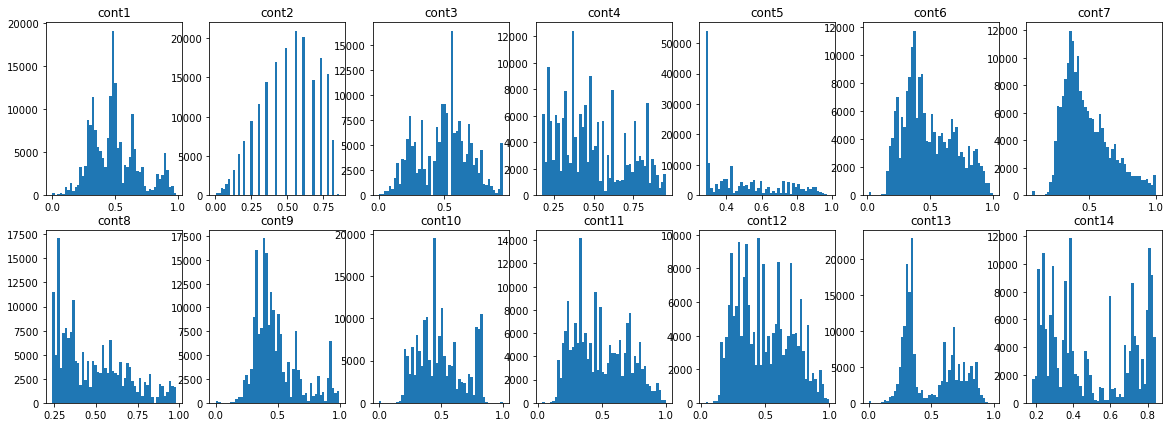

In [11]:
fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(20, 7))

k=0
for j in range(2):
    for i in range(7):
        ax[j,i].hist(train[cont_features[k]], bins=50)
        ax[j,i].set_title(cont_features[k])
        k+=1
;


Maybe cont2 can be changed to categorical variable.

In [15]:
c2_un = train['cont2'].nunique()
print('Cont2 has {} unique elements'.format(c2_un))

Cont2 has 33 unique elements


Hard to determine without context on what the variable represents, might be something like age in which case continuous makes sense. 

Let's look at features with correlation higher than 50%

In [19]:
cor = train[cont_features + ['loss']].corr()
cor[np.abs(cor)>0.5]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
cont1,1.000000,NaN,NaN,NaN,NaN,0.758315,NaN,NaN,0.929912,0.808551,0.596090,0.614225,0.534850,NaN,NaN
cont2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont4,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.52874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont6,0.758315,NaN,NaN,NaN,NaN,1.000000,0.658918,NaN,0.797544,0.883351,0.773745,0.785144,0.815091,NaN,NaN
cont7,NaN,NaN,NaN,NaN,NaN,0.658918,1.000000,NaN,NaN,NaN,0.747108,0.742712,NaN,NaN,NaN
cont8,NaN,NaN,NaN,0.52874,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cont9,0.929912,NaN,NaN,NaN,NaN,0.797544,NaN,NaN,1.000000,0.785697,0.608000,0.626656,0.642028,NaN,NaN
cont10,0.808551,NaN,NaN,NaN,NaN,0.883351,NaN,NaN,0.785697,1.000000,0.702896,0.713812,0.707876,NaN,NaN


There are some highly correlated features in there. 

### Target variable

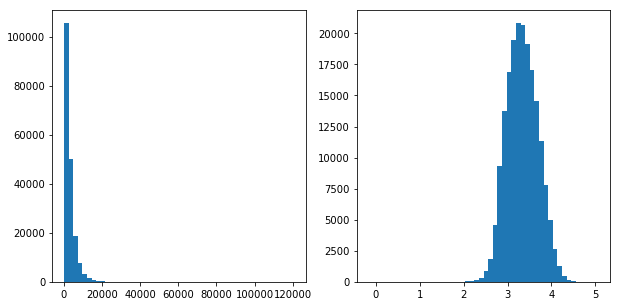

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(train['loss'], bins=50);
ax[1].hist(np.log10(train['loss']), bins=50);

## Test +  sample submission

In [7]:
test.shape

(125546, 131)

In [6]:
sample_submission.shape

(125546, 2)

In [12]:
assert pd.Series(test['id'] == sample_submission['id']).all()

# Evaluation

Let's define a Lorenz curve 

In [26]:

l = [0,5,2,3]
print(np.argsort(l))

np.array(l)[np.argsort(l)]

[0 2 3 1]


array([0, 2, 3, 5])

In [37]:
np.array(l).cumsum()

array([ 0,  5,  7, 10])

In [46]:
def lorenz_curve(risk_proxy, loss):
    idx = np.argsort(risk_proxy)
    
    ordered_loss = loss[idx]
    cum_loss =  ordered_loss.cumsum()
    
    return cum_loss

risk_proxy_example = np.array([1,2,4,6,4,2,1])
loss_example = np.array([0,1,0,3,4,0,0,])

lorenz_curve(risk_proxy_example, loss_example)

array([0, 0, 1, 1, 1, 5, 8])

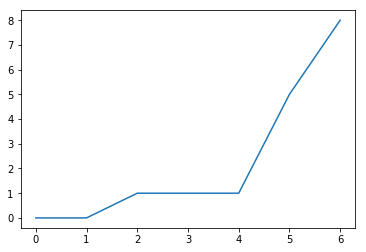

In [50]:
fig, ax = plt.subplots()

y = lorenz_curve(risk_proxy_example, loss_example)

ax.plot(np.arange(len(y)), y);

# GLM


# XGB

# Random Forest

# Ensemble

# Shap values

# Results 

# Kaggle 